In [1]:
# student Id : 28280016
# Name: Zhiyue Li
# Email : zlii0010@student.monash.edu
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import sys
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import random
from IPython.display import clear_output

In [2]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

## Dataloader

the following class reads the data for the third assignment and creates a torch dataset object for it. With this, you can easily use a dataloader to train your model. 

Due to size limit on moodle, the data for this assignment should be obtained from 

https://drive.google.com/file/d/1Nj8HK180dVj-Y9b2w2hRGz726c8OTF_C/view?usp=sharing


Make sure that the file "hw3.npz" is located properly (in this example, it should be in the same folder as this notebook.

 



In [3]:
class STLData(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None):
        data = np.load('hw3.npz')
        if trn_val_tst == 0:
            #trainloader
            self.images = data['arr_0']
            self.labels = data['arr_1']
        elif trn_val_tst == 1:
            #valloader
            self.images = data['arr_2']
            self.labels = data['arr_3']
        else:
            #testloader
            self.images = data['arr_4']
            self.labels = data['arr_5']
            
        self.images = np.float32(self.images)/1.0
        #self.images = np.unit8(self.images/1.0)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, labels

In [4]:
## this is for Q2.2
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomCrop(64),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])])

In [5]:
#Prepare a composition of transforms
#transforms.Compose will perform the transforms in order
#NOTE some transform only take in a PIL image, others only a Tensor
#EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
#Refer to documentation
#https://pytorch.org/docs/stable/torchvision/transforms.html
#image_size = 96
#imgs = self.transform(np.unit8(imgs))

#choices = transforms.RandomChoice([transforms.RandomAffine(30),
#                                   transforms.RandomPerspective()])

#transform = transforms.Compose([
 #                               T.ToPILImage(),
  #                              #T.RandomResizedCrop(64,ratio = (1,1)),
                                #T.RandomApply([choices], 0.5),
   #                             T.RandomCrop(image_size),      #Random crop
    #                            T.RandomHorizontalFlip(p=0.5), #random horizontal flip with 50% chance
     #                           T.ToTensor(),
      #                          T.Normalize(mean=[0.485, 0.456, 0.406],
  #                                          std=[0.229, 0.224, 0.225])])


#npimg = np.transpose(npimg,(2,0,1))
#trn_val_tst = self.transform(np.uint8(trn_val_tst))

#train_set = STLData(trn_val_tst=0, transform=transform) 
#val_set = STLData(trn_val_tst=1, transform=transform) 
#test_set = STLData(trn_val_tst=2, transform=transform) 

IndentationError: unexpected indent (<ipython-input-5-e61048a23a07>, line 21)

Here is an example of how you can create a dataloader. 
First read the data. Note that the STL10 class can work with torchvision.transforms that are required in HW3

In [6]:
#sys.getsizeof(train_set)
train_set = STLData(trn_val_tst=0, transform=torchvision.transforms.ToTensor()) 
val_set = STLData(trn_val_tst=1, transform=torchvision.transforms.ToTensor()) 
test_set = STLData(trn_val_tst=2, transform=torchvision.transforms.ToTensor()) 


Now for a batchsize of 100, you can have a dataloader as follows for your training data. 

In [7]:
batch_size = 100 
n_workers = multiprocessing.cpu_count()
n_workers = 0
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)

Let's visualize some of the images

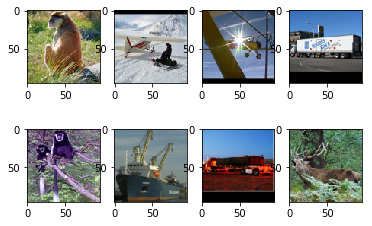

In [8]:
image_batch, labels = next(iter(trainloader))
for tmpC1 in range(8):    
    img = np.moveaxis(image_batch[tmpC1].numpy(),0,2)
    plt.subplot(2,4,tmpC1+1)
    plt.imshow(img/255)

In [9]:
# Set device to GPU_index if GPU is available 
GPU_index = 0
device = torch.device(GPU_index if torch.cuda.is_available() else 'cpu')

n_epochs = 30
learning_rate = 1e-3

training_loss_logger = []
training_acc_logger =[]

validation_loss_logger = []
validation_acc_logger = []

test_loss_logger = []
test_acc_logger = []

In [10]:

def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc


class Model(nn.Module):
    def __init__(self):

        super(Model, self).__init__()
        
        self.convblk1 = nn.Sequential (nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2),
                                    nn.ReLU(),
                                    nn.Conv2d(32, 32, kernel_size=1, padding=0, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                   
                                   )
        
        self.convblk2 = nn.Sequential (nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, kernel_size=1, padding=0, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                   
                                   )
        
        self.convblk3 = nn.Sequential (nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, kernel_size=1, padding=0, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                   
                                   )
        
        self.convblk4 = nn.Sequential (nn.Conv2d(128, 192, kernel_size=3, padding=1, stride=2),
                                    nn.ReLU(),
                                    nn.Conv2d(192, 192, kernel_size=1, padding=0, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(192, 192, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                   
                                   )
              
        self.avgpool = nn.AvgPool2d(6)
        
        self.linear1 = nn.Linear(192, 10)
      
        
    def forward(self, x):
    
        out1 = self.convblk1(x)
        out2 = self.convblk2(out1)
        out3 = self.convblk3(out2)
        out4 = self.convblk4(out3)
        out5 = self.avgpool(out4)
        out5 = out5.view(out5.shape[0],-1)
        out6 = self.linear1(out5)
        
        return out6
      

#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, Loss_fun, loss_logger,acc_logger):
    
    #initialise counters
    epoch_loss = 0
    epoch_acc = 0
    
    #Set Network in train mode
    net.train()
    
    for i, (x, y) in enumerate(loader):
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.type(torch.LongTensor).to(device) # y is the corresponding label
                
        #Forward pass of image through network and get output
        fx = net(x)
        
        #Calculate loss using loss function
        loss = Loss_fun(fx, y)
        
        #calculate the accuracy
        acc = calculate_accuracy(fx, y)

        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()
        
        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #log the loss for plotting
        loss_logger.append(loss.item())
        acc_logger.append(acc.item())
        

        #clear_output is a handy function from the IPython.display module
        #it simply clears the output of the running cell
        
        #clear_output(True)
        print("TRAINING: | Itteration [%d/%d] | Loss %.2f |" %(i+1 ,len(loader) , loss.item()))
        
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger,acc_logger

#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#it WILL NOT be used to train out model
def evaluate(net, device, loader, Loss_fun, loss_logger = None,acc_logger= None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            
            #load images and labels to device
            x = x.to(device)
            y = y.type(torch.LongTensor).to(device) # y is the corresponding label
            
            #Forward pass of image through network
            fx = net(x)
            
            #Calculate loss using loss function
            loss = Loss_fun(fx, y)
            
            #calculate the accuracy
            acc = calculate_accuracy(fx, y)
            
            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            #log the loss for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())
            
            if not (acc_logger is None):
                acc_logger.append(acc.item())
                
            #clear_output(True)
            print("EVALUATION: | Itteration [%d/%d] | Loss %.2f | Accuracy %.2f%% |" %(i+1 ,len(loader), loss.item(), 100*(epoch_acc/ len(loader))))
    
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger,acc_logger




# Transfer for model to GPU
net = Model().to(device)
# Use the Adam optimiser to update the weights of the model
optimizer = optim.Adam(net.parameters(),lr = learning_rate)
#Cross entropy -- softmax over the class and negative log likelihood loss
loss_fn = nn.CrossEntropyLoss()


In [12]:
optim_valid_acc = 0
for epoch in range(n_epochs):
    print(epoch)

    #call the training function and pass training dataloader etc
    train_loss, train_acc, training_loss_logger,training_acc_logger= train(net, device, trainloader, optimizer, loss_fn, training_loss_logger,training_acc_logger)
    
    valid_loss, valid_acc, validation_loss_logger,validation_acc_logger = evaluate(net, device, valloader, loss_fn, validation_loss_logger,validation_acc_logger)

    #call the evaluate function and pass validation dataloader etc
    test_loss, test_acc, test_loss_logger,test_acc_logger = evaluate(net, device, testloader, loss_fn, test_loss_logger,test_acc_logger)

    #If this model has the highest performace on the validation set 
    #then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > optim_valid_acc):
        print("Saving Model")
        best_model={
            'epoch':                 epoch,
            'model_state_dict':      net.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(), 
            'train_acc':             train_acc,
            'valid_acc':             valid_acc,
        }
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')


plt.figure(figsize=(10,10))
train_x = np.linspace(0, n_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, n_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "r")

plt.title("Deep CNN")
plt.legend(["Traning Loss", "Validation Loss"])
plt.xlabel("Epoch")

plt.figure(figsize = (10,10))
train_x = np.linspace(0, n_epochs, len(training_acc_logger))
plt.plot(train_x, (training_acc_logger), c = "y")
valid_x = np.linspace(0, n_epochs, len(validation_acc_logger))
plt.plot(valid_x, (validation_acc_logger), c = "r")
valid_x = np.linspace(0, n_epochs, len(test_acc_logger))
plt.plot(valid_x, (test_acc_logger), c = "b")


plt.title("Deep CNN")
plt.legend(["Traning Accuracy", "Validation Accuracy","Testing Accuracy"])
plt.xlabel("Epoch")

0


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 2.00 GiB total capacity; 359.86 MiB already allocated; 0 bytes free; 408.00 MiB reserved in total by PyTorch)